In [50]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

def age_to_weeks(age_str):
    if pd.isnull(age_str):
        return np.nan
    match = re.match(r'(\d+)\s+(\w+)', age_str)
    if match:
        num, unit = int(match.group(1)), match.group(2).lower()
        if 'day' in unit:
            return num // 7
        elif 'week' in unit:
            return num
        elif 'month' in unit:
            return num * 4
        elif 'year' in unit:
            return num * 52
    return np.nan

In [51]:
# === Load Data ===
train_df = pd.read_csv("train.csv").sample(n=25000, random_state=42)

# === Target & ID ===
target_col = "Outcome Type"
id_col = "Id"

# Drop high-leakage or irrelevant features
drop_cols = ['Found Location', 'Date of Birth', 'Name', target_col, id_col]
X = train_df.drop(columns=drop_cols, errors='ignore')
y = train_df[target_col]

# === Encode Target ===
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

# === Handle Age and Time Features ===
# Convert 'Age upon Intake' to 'Age in Weeks'
def age_to_weeks(age):
    try:
        return int(age) // 7 if pd.notnull(age) else 0
    except:
        return 0

X['Age in Weeks'] = X['Age upon Intake'].apply(age_to_weeks)

# Bucket age into categories
def bucket_age(weeks):
    if weeks < 26:
        return "Baby"
    elif weeks < 105:
        return "Young"
    elif weeks < 365:
        return "Adult"
    else:
        return "Senior"

X['Age Bucket'] = X['Age in Weeks'].apply(bucket_age)

# Drop raw age string + optional numeric age
X.drop(columns=['Age upon Intake', 'Age in Weeks'], inplace=True)

# === Handle datetime columns (Intake Time, Outcome Time) ===
datetime_format = "%m/%d/%Y %I:%M:%S %p"
X['Intake Time'] = pd.to_datetime(X['Intake Time'], format=datetime_format, errors='coerce')
X['Outcome Time'] = pd.to_datetime(X['Outcome Time'], format=datetime_format, errors='coerce')

# Add new column: total time in shelter (Days)
X['Time in Shelter (Days)'] = (X['Outcome Time'] - X['Intake Time']).dt.total_seconds() / (60*60*24)

# Drop raw datetime columns
X.drop(columns=['Intake Time', 'Outcome Time'], inplace=True)

# === Fill missing values ===
X = X.fillna("Unknown")

# === Bucket Color Feature ===
def bucket_color(color):
    color = str(color).lower()
    if "black" in color:
        return "Black"
    elif "white" in color:
        return "White"
    elif "brown" in color or "chocolate" in color:
        return "Brown"
    elif "tan" in color or "fawn" in color:
        return "Tan"
    elif "blue" in color or "gray" in color or "grey" in color:
        return "Gray"
    elif "orange" in color or "red" in color:
        return "Orange/Red"
    elif "tricolor" in color:
        return "Tricolor"
    elif "tabby" in color:
        return "Tabby"
    elif "brindle" in color:
        return "Brindle"
    elif "yellow" in color:
        return "Yellow"
    else:
        return "Other"

X['Color Bucket'] = X['Color'].apply(bucket_color)
X.drop(columns=['Color'], inplace=True)

# One-hot encode Color and Age Buckets (they are small, so good for KNN)
X = pd.get_dummies(X, columns=['Color Bucket', 'Age Bucket'], drop_first=True)

# === Selectively one-hot encode low-cardinality categorical columns ===
# Avoid high-cardinality ones like 'Breed' for KNN
low_card_cols = [col for col in X.select_dtypes(include='object').columns if X[col].nunique() <= 10]
X = pd.get_dummies(X, columns=low_card_cols, drop_first=True)

# Optionally: drop remaining object columns (e.g., unencoded 'Breed')
X.drop(columns=[col for col in X.columns if X[col].dtype == 'object'], inplace=True)

# === Ensure all features are numeric ===
X = X.astype(float)

# === Feature selection (Optional) ===
# Drop low variance features
selector = VarianceThreshold(threshold=0.0001)
X = pd.DataFrame(selector.fit_transform(X), columns=X.columns[selector.get_support()])

# === Show final data ===
print(X.head())


   Time in Shelter (Days)  Color Bucket_Brown  Color Bucket_Gray  \
0               10.875694                 0.0                1.0   
1                2.700000                 1.0                0.0   
2                9.667361                 0.0                0.0   
3                8.998611                 0.0                0.0   
4                0.050694                 1.0                0.0   

   Color Bucket_Orange/Red  Color Bucket_Other  Color Bucket_Tabby  \
0                      0.0                 0.0                 0.0   
1                      0.0                 0.0                 0.0   
2                      0.0                 1.0                 0.0   
3                      0.0                 0.0                 0.0   
4                      0.0                 0.0                 0.0   

   Color Bucket_Tan  Color Bucket_Tricolor  Color Bucket_White  \
0               0.0                    0.0                 0.0   
1               0.0                   

In [52]:
# === Train-validation split ===
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# === Scale only for MLP ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Reduce to 50 components (or 0.95 for variance-based)
pca = PCA(n_components=0.95)  # Keep enough components to retain 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

print(f"PCA reduced to {pca.n_components_} components")


# === Models ===
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'MLP Neural Net': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5)
}

# === Training and Evaluation ===
for name, model in models.items():
    print(f"\n--- {name} ---")
    
    # Use scaled data for KNN and MLP
    if 'MLP' in name or 'KNN' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
    
    acc = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {acc:.4f}")


PCA reduced to 16 components

--- Random Forest ---
Validation Accuracy: 0.6272

--- HistGradientBoosting ---
Validation Accuracy: 0.7256

--- MLP Neural Net ---
Validation Accuracy: 0.7032

--- KNN (k=5) ---
Validation Accuracy: 0.6810


In [53]:
from sklearn.model_selection import cross_val_score

# === Scale features for MLP ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Define models ===
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'MLP Neural Net': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
}

# === Cross-validation for each model ===
print("Performing 5-fold cross-validation...\n")
for name, model in models.items():
    print(f"--- {name} ---")
    if 'MLP' in name:
        scores = cross_val_score(model, X=X_scaled, y=y_encoded, cv=5)
    else:
        scores = cross_val_score(model, X=X, y=y_encoded, cv=5)
    print(f"CV Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    
print("\n=== Tuning K for KNN ===")
for k in [1, 3, 5, 7, 10, 15, 20]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_val_scaled)
    acc = accuracy_score(y_val, y_pred)
    print(f"KNN (k={k}) Accuracy: {acc:.4f}")


Performing 5-fold cross-validation...

--- Random Forest ---
CV Accuracy: 0.6299 ± 0.0040
--- HistGradientBoosting ---
CV Accuracy: 0.7226 ± 0.0034
--- MLP Neural Net ---
CV Accuracy: 0.6992 ± 0.0048

=== Tuning K for KNN ===
KNN (k=1) Accuracy: 0.6198
KNN (k=3) Accuracy: 0.6692
KNN (k=5) Accuracy: 0.6810
KNN (k=7) Accuracy: 0.6898
KNN (k=10) Accuracy: 0.7010
KNN (k=15) Accuracy: 0.7052
KNN (k=20) Accuracy: 0.6996


In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier

params = {
    'learning_rate': [0.05, 0.1],
    'max_iter': [100, 200],
    'max_depth': [None, 5, 10],
    'l2_regularization': [0.0, 0.1, 0.5],
}
grid = GridSearchCV(
    HistGradientBoostingClassifier(random_state=42),
    param_grid=params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid.fit(X, y_encoded)
print("Best Score:", grid.best_score_)
print("Best Params:", grid.best_params_)


Best Score: 0.7236800000000001
Best Params: {'l2_regularization': 0.5, 'learning_rate': 0.05, 'max_depth': 10, 'max_iter': 200}


In [55]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ('histgb', HistGradientBoostingClassifier(random_state=42)),
        ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors=15, weights='distance', metric='manhattan'))
    ],
    voting='soft'  # use probabilities
)

ensemble.fit(X_train_pca, y_train)
print("Ensemble Accuracy:", accuracy_score(y_val, ensemble.predict(X_val_pca)))


Ensemble Accuracy: 0.7134


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Pick the model you want to test
model = HistGradientBoostingClassifier(random_state=42)

# Store accuracies
accuracies = []

# Repeat 100 times
for i in range(100):
    X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
        X_train_pca, y_train, test_size=0.2, random_state=i
    )
    model.fit(X_train_sub, y_train_sub)
    y_pred = model.predict(X_val_sub)
    acc = accuracy_score(y_val_sub, y_pred)
    accuracies.append(acc)

# Summary
accuracies = np.array(accuracies)
print(f"\n✅ 100-Trial Evaluation for {model.__class__.__name__}")
print(f"- Mean Accuracy:     {accuracies.mean():.4f}")
print(f"- Best Accuracy:     {accuracies.max():.4f}")
print(f"- Worst Accuracy:    {accuracies.min():.4f}")
print(f"- Std Deviation:     {accuracies.std():.4f}")



✅ 100-Trial Evaluation for HistGradientBoostingClassifier
- Mean Accuracy:     0.6996
- Best Accuracy:     0.7155
- Worst Accuracy:    0.6790
- Std Deviation:     0.0072


In [57]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# === Split and Scale ===
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# === Dimensionality Reduction with PCA ===
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

print(f"PCA reduced to {pca.n_components_} components, retaining {pca.explained_variance_ratio_.sum():.2%} of variance")

# === Handle Imbalance with SMOTE ===
smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_pca, y_train)

# === Tune and Evaluate Improved KNN ===
print("\n=== Tuning Improved KNN ===")
for k in [5, 10, 15, 20, 25]:
    knn = KNeighborsClassifier(
        n_neighbors=k,
        weights='distance',       # Weight votes by distance
        metric='manhattan'        # Try L1 distance
    )
    knn.fit(X_resampled, y_resampled)
    y_pred = knn.predict(X_val_pca)
    acc = accuracy_score(y_val, y_pred)
    top3 = top_k_accuracy_score(y_val, knn.predict_proba(X_val_pca), k=3)
    print(f"KNN (k={k}) Accuracy: {acc:.4f} | Top-3 Accuracy: {top3:.4f}")


PCA reduced to 16 components, retaining 95.65% of variance

=== Tuning Improved KNN ===
KNN (k=5) Accuracy: 0.5348 | Top-3 Accuracy: 0.9118
KNN (k=10) Accuracy: 0.5410 | Top-3 Accuracy: 0.9288
KNN (k=15) Accuracy: 0.5450 | Top-3 Accuracy: 0.9350
KNN (k=20) Accuracy: 0.5466 | Top-3 Accuracy: 0.9374
KNN (k=25) Accuracy: 0.5492 | Top-3 Accuracy: 0.9386


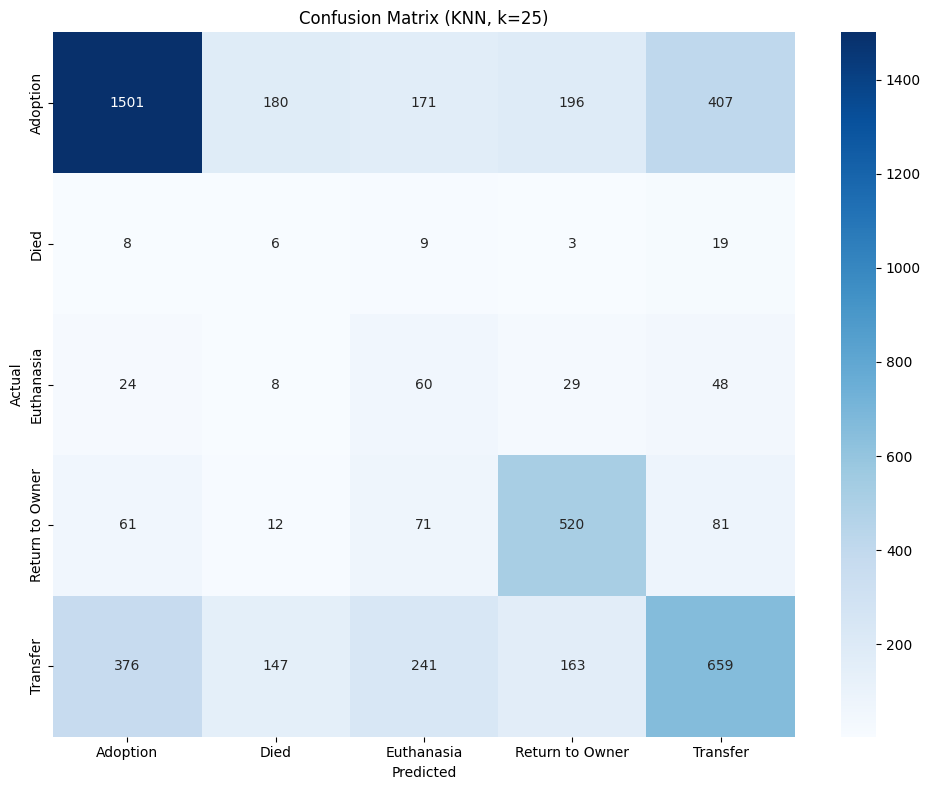

{'Adoption': np.int64(0), 'Died': np.int64(1), 'Euthanasia': np.int64(2), 'Return to Owner': np.int64(3), 'Transfer': np.int64(4)}


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# === Refit KNN (k=25) with best config ===
best_knn = KNeighborsClassifier(
    n_neighbors=25,
    weights='distance',
    metric='manhattan'
)
best_knn.fit(X_resampled, y_resampled)
y_pred = best_knn.predict(X_val_pca)

# === Decode labels for display (optional) ===
labels = le_y.inverse_transform(sorted(set(y_encoded)))

# === Generate confusion matrix ===
cm = confusion_matrix(y_val, y_pred, labels=range(len(labels)))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (KNN, k=25)')
plt.tight_layout()
plt.show()

# This will show you which label (string) maps to which encoded value
print(dict(zip(le_y.classes_, le_y.transform(le_y.classes_))))


In [59]:
# === Train/Validation Split ===
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# === Models ===
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'MLP Neural Net': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
}

# === Train and Evaluate ===
for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {acc:.4f}")


--- Random Forest ---
Validation Accuracy: 0.6272

--- HistGradientBoosting ---
Validation Accuracy: 0.7256

--- MLP Neural Net ---
Validation Accuracy: 0.7142
